# Quantization Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [4]:
class DifferentiableQuantization(nn.Module):
    def __init__(self, num_bins=15, hardness=10.0, normalize_input=True, rescale_output=True):
        """
        Args:
            num_bins (int): Number of quantization bins (default 15).
            hardness (float): Controls sigmoid sharpness; higher = closer to step function.
            normalize_input (bool): Whether to normalize input to [0, num_bins] before quantizing.
            rescale_output (bool): Whether to rescale output back to input's original value range.
        """
        super().__init__()
        self.num_bins = num_bins
        self.hardness = hardness
        self.normalize_input = normalize_input
        self.rescale_output = rescale_output

        # Initialize bin centers at [0.5, 1.5, ..., 14.5] for num_bins = 15
        init_bins = torch.linspace(0.5, num_bins - 0.5, steps=num_bins)
        self.bins = nn.Parameter(init_bins)

    def forward(self, x):
        """
        Args:
            x (Tensor): Input tensor of shape (B, C, H, W)
        Returns:
            Tensor: Quantized output of shape (B, C, H, W)
        """
        orig_min, orig_max = x.min(), x.max()

        if self.normalize_input:
            qmin = 0.0
            qmax = float(self.num_bins)
            scale = (orig_max - orig_min) / (qmax - qmin)
            scale = max(scale, 1e-4)
            x = (x - orig_min) / (orig_max - orig_min + 1e-4) * (qmax - qmin)

        # Expand for broadcasting
        x_expanded = x.unsqueeze(-1)                        # Shape: [B, C, H, W, 1]
        bin_centers = self.bins.view(1, 1, 1, 1, -1)        # Shape: [1, 1, 1, 1, num_bins]

        # Sum of sigmoid activations
        y = torch.sigmoid(self.hardness * (x_expanded - bin_centers)).sum(dim=-1)

        if self.normalize_input and self.rescale_output:
            y = y * scale + orig_min

        return y


## Test 

In [5]:
from quantization import DifferentiableQuantization
quantizer = DifferentiableQuantization(num_bins=15, hardness=10.0)


In [6]:
# Simulated input: gradient from 0 to 15
x = torch.linspace(0, 15, steps=100).view(1, 1, 10, 10)  # Shape: (1, 1, 10, 10)


In [7]:
with torch.no_grad():
    y = quantizer(x)


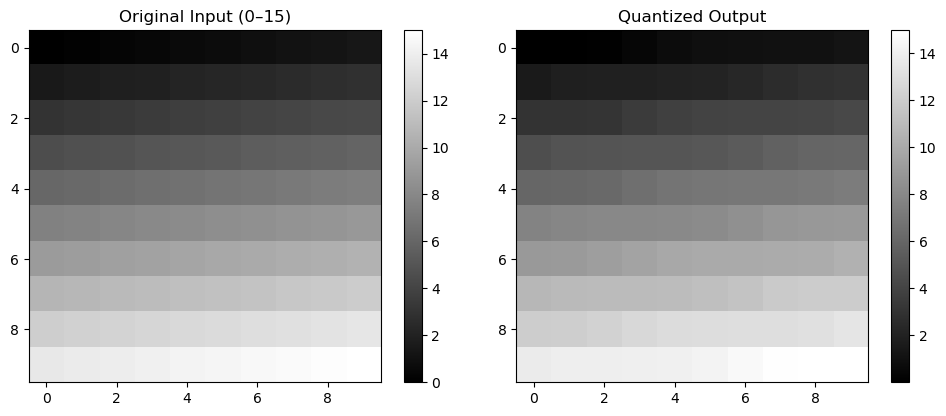

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(x.squeeze().numpy(), cmap='gray')
plt.title("Original Input (0–15)")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(y.squeeze().numpy(), cmap='gray')
plt.title("Quantized Output")
plt.colorbar()
plt.tight_layout()
plt.show()
